In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math
import os
import yfinance as yf
import pandas_datareader as pdr
import datetime as dt
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [21]:
yf.pdr_override()
sp500 = yf.download('SPY', start='2010-01-01', end='2022-10-29')
sp500

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,112.370003,113.389999,111.510002,113.330002,88.454178,118944600
2010-01-05,113.260002,113.680000,112.849998,113.629997,88.688339,111579900
2010-01-06,113.519997,113.989998,113.430000,113.709999,88.750793,116074400
2010-01-07,113.500000,114.330002,113.180000,114.190002,89.125427,131091100
2010-01-08,113.889999,114.620003,113.660004,114.570000,89.422005,126402800
...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,377.138184,85436900
2022-10-25,378.790009,385.250000,378.670013,384.920013,383.160522,78846300
2022-10-26,381.619995,387.579987,381.350006,382.019989,380.273773,104087300


In [25]:
spy = sp500.loc[sp500.index >= '2016-01-01', :]
spy.loc[:, 'return'] = np.log(spy.Close/spy.Close.shift(1))
spy.loc[:, 'cumreturn'] = spy['return'].cumsum().apply(np.exp)
spy['cumreturn'].fillna(1, inplace=True)
spy

C:\Users\kmlee\AppData\Local\Temp\ipykernel_6260\3876723242.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy.loc[:, 'return'] = np.log(spy.Close/spy.Close.shift(1))
C:\Users\kmlee\AppData\Local\Temp\ipykernel_6260\3876723242.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy.loc[:, 'cumreturn'] = spy['return'].cumsum().apply(np.exp)
C:\Users\kmlee\AppData\Local\Temp\ipykernel_6260\3876723242.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn
Date,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,177.237411,222353500,NaN,1.000000
2016-01-05,201.399994,201.899994,200.050003,201.360001,177.537170,110845800,0.001690,1.001691
2016-01-06,198.339996,200.059998,197.600006,198.820007,175.297714,152112600,-0.012694,0.989056
2016-01-07,195.330002,197.440002,193.589996,194.050003,171.092026,213436100,-0.024284,0.965327
2016-01-08,195.190002,195.850006,191.580002,191.919998,169.213989,209817200,-0.011037,0.954731
...,...,...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,377.138184,85436900,0.012162,1.884738
2022-10-25,378.790009,385.250000,378.670013,384.920013,383.160522,78846300,0.015842,1.914834
2022-10-26,381.619995,387.579987,381.350006,382.019989,380.273773,104087300,-0.007563,1.900408


In [63]:
indicators = ['Close_copied', 'Volume']
symbol_lag_list = []
lag = 100
period = 30
threshold = 0.02

sp500.loc[:, 'Close_copied'] = sp500.Close.copy()

for indicator in indicators:
    temp_lst= [indicator]
    for i in range(1, lag):
        sp500[f'{indicator}_{i}'] = sp500[indicator].shift(i)
        temp_lst.append(f'{indicator}_{i}')
    tempT = sp500.loc[:, temp_lst].transpose()
    scaler = MinMaxScaler(feature_range=(0,1))
    sp500.loc[:, temp_lst] = scaler.fit_transform(tempT).transpose()

train = sp500.loc[(sp500.index >= '2011-01-01') & (sp500.index < '2016-01-01'), :]
test = sp500.loc[sp500.index >= '2016-01-01', :]

dfs = [train, test]
for df in dfs:
    df.loc[:, 'Close_shifted'] = df.Close.shift(-period+1)
    df.loc[:, 'Target'] = ((df.Close_shifted-df.Open)/df.Open).shift(-1)
    df.loc[:, 'Target_direction'] = np.where(df.Target > 0, 1, 0)
    df.loc[:, 'Target_direction'] = np.where(df.Target < -threshold, -1, df.Target_direction)

C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\kmlee\AppData\Local\Tem

In [64]:
train

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn,Close_copied,Close_copied_1,...,Volume_93,Volume_94,Volume_95,Volume_96,Volume_97,Volume_98,Volume_99,Close_shifted,Target,Target_direction
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-03,126.709999,127.599998,125.699997,127.050003,101.109329,0.483447,0.010285,1.121062,1.000000,0.940421,...,0.191810,0.295471,0.142333,0.122662,0.077649,0.097599,0.246893,133.429993,0.044608,1
2011-01-04,127.330002,127.370003,126.190002,126.980003,101.053589,0.475823,-0.000551,1.120445,0.996792,1.000000,...,0.106448,0.191810,0.295471,0.142333,0.122662,0.077649,0.097599,133.009995,0.057434,1
2011-01-05,126.580002,127.720001,126.459999,127.639999,101.578873,0.455918,0.005184,1.126268,1.000000,0.970549,...,0.322857,0.106448,0.191810,0.295471,0.142333,0.122662,0.077649,133.850006,0.051374,1
2011-01-06,127.690002,127.830002,127.010002,127.389999,101.379913,0.389522,-0.001961,1.124062,0.988844,1.000000,...,0.268687,0.322857,0.106448,0.191810,0.295471,0.142333,0.122662,134.250000,0.054641,1
2011-01-07,127.559998,127.769997,126.150002,127.139999,101.180931,0.583765,-0.001964,1.121857,0.977689,0.988844,...,0.175508,0.268687,0.322857,0.106448,0.191810,0.295471,0.142333,134.529999,0.041476,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24,205.720001,206.330002,205.419998,205.679993,181.346069,0.023880,-0.001652,1.814877,0.775811,0.790139,...,0.269900,0.968861,0.579912,0.192920,0.410898,0.398472,0.192808,NaN,NaN,0
2015-12-28,204.860001,205.259995,203.940002,205.210007,180.931717,0.060822,-0.002288,1.810730,0.756005,0.775811,...,0.129697,0.269900,0.968861,0.579912,0.192920,0.410898,0.398472,NaN,NaN,0
2015-12-29,206.509995,207.789993,206.470001,207.399994,182.862595,0.117727,0.010615,1.830054,0.848293,0.756005,...,0.182799,0.129697,0.269900,0.968861,0.579912,0.192920,0.410898,NaN,NaN,0


In [65]:
test

,Open,High,Low,Close,Adj Close,Volume,return,cumreturn,Close_copied,Close_copied_1,...,Volume_93,Volume_94,Volume_95,Volume_96,Volume_97,Volume_98,Volume_99,Close_shifted,Target,Target_direction
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,177.237411,0.393755,-0.014078,1.773758,0.579435,0.699536,...,1.000000,0.975807,0.120457,0.182799,0.129697,0.269900,0.968861,189.779999,-0.042304,-1
2016-01-05,201.399994,201.899994,200.050003,201.360001,177.537170,0.156467,0.001690,1.776758,0.593763,0.579435,...,1.000000,1.000000,0.975807,0.120457,0.182799,0.129697,0.269900,192.880005,-0.031512,-1
2016-01-06,198.339996,200.059998,197.600006,198.820007,175.297714,0.244282,-0.012694,1.754346,0.486726,0.593763,...,1.000000,1.000000,1.000000,0.975807,0.120457,0.182799,0.129697,192.089996,-0.017048,0
2016-01-07,195.330002,197.440002,193.589996,194.050003,171.092026,0.374778,-0.024284,1.712256,0.285714,0.486726,...,0.694513,1.000000,1.000000,1.000000,0.975807,0.120457,0.182799,192.000000,-0.002101,0
2016-01-08,195.190002,195.850006,191.580002,191.919998,169.213989,0.367077,-0.011037,1.693462,0.195954,0.285714,...,0.626538,0.694513,1.000000,1.000000,1.000000,0.975807,0.120457,194.779999,-0.003575,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,377.138184,0.372360,0.012162,3.343069,0.305031,0.242412,...,0.388032,0.148145,0.035213,0.009077,0.000000,0.000000,0.017915,NaN,NaN,0
2022-10-25,378.790009,385.250000,378.670013,384.920013,383.160522,0.311773,0.015842,3.396453,0.387750,0.305031,...,0.579055,0.388032,0.148145,0.035213,0.009077,0.000000,0.000000,NaN,NaN,0
2022-10-26,381.619995,387.579987,381.350006,382.019989,380.273773,0.543812,-0.007563,3.370864,0.348099,0.387750,...,0.239366,0.579055,0.388032,0.148145,0.035213,0.009077,0.000000,NaN,NaN,0


In [11]:
def create_model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(filepath=f'{os.getcwd()}\Conv1DFC_models\model_{model_name}',
                                              save_best_only=True)

In [39]:
def create_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='loss',
                                           patience=2)

In [29]:
lagged_indicators = []
for indicator in indicators:
    lagged_indicators.append(indicator)
    for i in range(1, lag):
        lagged_indicators.append(f'{indicator}_{i}')
lagged_indicators

['Close_copied',
 'Close_copied_1',
 'Close_copied_2',
 'Close_copied_3',
 'Close_copied_4',
 'Close_copied_5',
 'Close_copied_6',
 'Close_copied_7',
 'Close_copied_8',
 'Close_copied_9',
 'Close_copied_10',
 'Close_copied_11',
 'Close_copied_12',
 'Close_copied_13',
 'Close_copied_14',
 'Close_copied_15',
 'Close_copied_16',
 'Close_copied_17',
 'Close_copied_18',
 'Close_copied_19',
 'Close_copied_20',
 'Close_copied_21',
 'Close_copied_22',
 'Close_copied_23',
 'Close_copied_24',
 'Close_copied_25',
 'Close_copied_26',
 'Close_copied_27',
 'Close_copied_28',
 'Close_copied_29',
 'Close_copied_30',
 'Close_copied_31',
 'Close_copied_32',
 'Close_copied_33',
 'Close_copied_34',
 'Close_copied_35',
 'Close_copied_36',
 'Close_copied_37',
 'Close_copied_38',
 'Close_copied_39',
 'Close_copied_40',
 'Close_copied_41',
 'Close_copied_42',
 'Close_copied_43',
 'Close_copied_44',
 'Close_copied_45',
 'Close_copied_46',
 'Close_copied_47',
 'Close_copied_48',
 'Close_copied_49',
 'Close_copi

In [78]:
def get_dataset(df, istrain=True):
    temp = df.iloc[:-period, :] if istrain else df
    x, y = temp.loc[:, lagged_indicators].to_numpy(), temp.loc[:, 'Target_direction'].to_numpy()
    x_reshaped = np.array([np.transpose(row.reshape(2, lag)) for row in x])
    encoder = OneHotEncoder()
    y = encoder.fit_transform(y.reshape(-1, 1)).todense()
    return x_reshaped, y

In [79]:
x, y = get_dataset(train)
x.shape, y.shape

((1228, 100, 2), (1228, 3))

In [121]:
tf.random.set_seed(0)

inputs = layers.Input(shape=(lag,2), dtype=tf.float32)
x = layers.Conv1D(4, kernel_size=3, activation='relu')(inputs)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [122]:
trainx, trainy = get_dataset(train)
history = model.fit(trainx,
                    trainy,
                    epochs=100,
                    batch_size=32,
                    callbacks=[create_early_stopping()])

file_loc = f'{os.getcwd()}\Conv1DFC_model'
tf.keras.models.save_model(model, file_loc)

Epoch 1/100
39/39 [==============================] - 1s 4ms/step - loss: 0.8900 - accuracy: 0.6531
Epoch 2/100
39/39 [==============================] - 0s 3ms/step - loss: 0.8325 - accuracy: 0.6645
Epoch 3/100
39/39 [==============================] - 0s 3ms/step - loss: 0.8106 - accuracy: 0.6661
Epoch 4/100
39/39 [==============================] - 0s 3ms/step - loss: 0.7928 - accuracy: 0.6775
Epoch 5/100
39/39 [==============================] - 0s 3ms/step - loss: 0.7812 - accuracy: 0.6849
Epoch 6/100
39/39 [==============================] - 0s 3ms/step - loss: 0.7436 - accuracy: 0.7052
Epoch 7/100
39/39 [==============================] - 0s 3ms/step - loss: 0.7166 - accuracy: 0.6995
Epoch 8/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6950 - accuracy: 0.7020
Epoch 9/100
39/39 [==============================] - 0s 5ms/step - loss: 0.6719 - accuracy: 0.7305
Epoch 10/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6628 - accuracy: 0.7223
Epoch 11/

INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_model\assets


INFO:tensorflow:Assets written to: C:\Users\kmlee\Desktop\Quant-Projects\SP500\Conv1DFC_strategy\Conv1DFC_model\assets


In [123]:
testx, testy = get_dataset(test, False)
testx.shape, testy.shape

((1719, 100, 2), (1719, 3))

In [124]:
test_preds = np.argmax(model.predict(testx), axis=1)-1
test_preds

54/54 [==============================] - 0s 2ms/step


array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [125]:
test['prediction'] = test_preds
test

C:\Users\kmlee\AppData\Local\Temp\ipykernel_6260\4283952095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['prediction'] = test_preds


,Open,High,Low,Close,Adj Close,Volume,return,cumreturn,Close_copied,Close_copied_1,...,Volume_95,Volume_96,Volume_97,Volume_98,Volume_99,Close_shifted,Target,Target_direction,prediction,position
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,200.490005,201.029999,198.589996,201.020004,177.237411,0.393755,-0.014078,1.773758,0.579435,0.699536,...,0.120457,0.182799,0.129697,0.269900,0.968861,189.779999,-0.042304,-1,1,1.0
2016-01-05,201.399994,201.899994,200.050003,201.360001,177.537170,0.156467,0.001690,1.776758,0.593763,0.579435,...,0.975807,0.120457,0.182799,0.129697,0.269900,192.880005,-0.031512,-1,1,0.0
2016-01-06,198.339996,200.059998,197.600006,198.820007,175.297714,0.244282,-0.012694,1.754346,0.486726,0.593763,...,1.000000,0.975807,0.120457,0.182799,0.129697,192.089996,-0.017048,0,1,0.0
2016-01-07,195.330002,197.440002,193.589996,194.050003,171.092026,0.374778,-0.024284,1.712256,0.285714,0.486726,...,1.000000,1.000000,0.975807,0.120457,0.182799,192.000000,-0.002101,0,-1,0.0
2016-01-08,195.190002,195.850006,191.580002,191.919998,169.213989,0.367077,-0.011037,1.693462,0.195954,0.285714,...,1.000000,1.000000,1.000000,0.975807,0.120457,194.779999,-0.003575,0,-1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-24,375.890015,380.059998,373.109985,378.869995,377.138184,0.372360,0.012162,3.343069,0.305031,0.242412,...,0.035213,0.009077,0.000000,0.000000,0.017915,NaN,NaN,0,1,0.0
2022-10-25,378.790009,385.250000,378.670013,384.920013,383.160522,0.311773,0.015842,3.396453,0.387750,0.305031,...,0.148145,0.035213,0.009077,0.000000,0.000000,NaN,NaN,0,1,0.0
2022-10-26,381.619995,387.579987,381.350006,382.019989,380.273773,0.543812,-0.007563,3.370864,0.348099,0.387750,...,0.388032,0.148145,0.035213,0.009077,0.000000,NaN,NaN,0,1,0.0


Text(0.5, 1.0, 'Target')

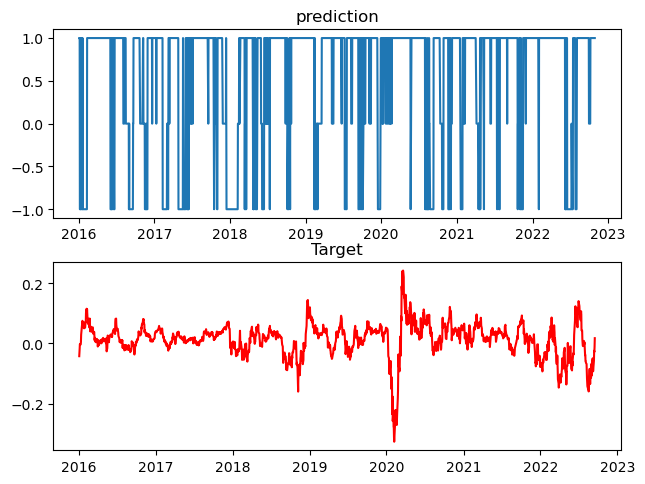

<Figure size 2000x1200 with 0 Axes>

In [126]:
fig, ax = plt.subplots(2, 1)
plt.figure(figsize=(20,12))
fig.tight_layout()
ax[0].plot(pd.to_datetime(test.index).date, test['prediction'])
ax[0].set_title('prediction')
ax[1].plot(test.index, test['Target'], color='red')
ax[1].set_title('Target')

Text(0.5, 1.0, 'predicted signal')

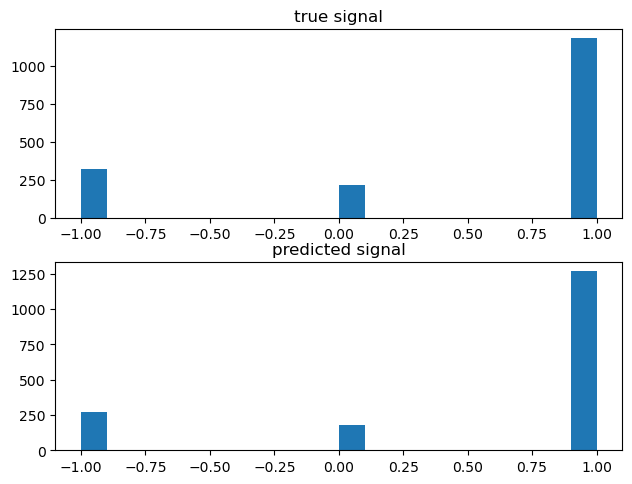

In [127]:
fig, ax = plt.subplots(2,1)
plt.tight_layout()
ax[0].hist(test.Target_direction, bins=20)
ax[0].set_title('true signal')
ax[1].hist(test.prediction, bins=20)
ax[1].set_title('predicted signal')

In [128]:
positions = []
for i in range(len(test.index)):
    if i%period == 0:
        position = test.iloc[i]['prediction']
    else:
        position = 0
    positions.append(position)
test.loc[:, 'position'] = positions

C:\Users\kmlee\AppData\Local\Temp\ipykernel_6260\3775372008.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'position'] = positions


In [129]:
strategies = pd.DataFrame()
strategies['return'] = (test['Target']*test['position'] + 1).shift(period)
strategies['strategy'] = np.log(strategies['return'])
strategies['cumstrategy'] = strategies['strategy'].cumsum().apply(np.exp)
strategies

,return,strategy,cumstrategy
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN
...,...,...,...
2022-10-24,1.0,0.0,2.109388
2022-10-25,1.0,0.0,2.109388
2022-10-26,1.0,0.0,2.109388


In [130]:
strategies.loc[strategies.index < '2021-01-01', :]

,return,strategy,cumstrategy
Date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,NaN,NaN,NaN
2016-01-06,NaN,NaN,NaN
2016-01-07,NaN,NaN,NaN
2016-01-08,NaN,NaN,NaN
...,...,...,...
2020-12-24,1.0,0.0,1.836076
2020-12-28,1.0,0.0,1.836076
2020-12-29,1.0,0.0,1.836076


In [140]:
hits = []
for i in range(len(test.loc[test.index < '2021-01-01', :])):
    if i%period == 0:
        hit = 1 if test.loc[test.index < '2021-01-01', :].iloc[i]['prediction'] == test.loc[test.index < '2021-01-01', :].iloc[i]['Target_direction'] else 0
        hits.append(hit)
np.array(hits).mean()*100

61.904761904761905

In [139]:
hits = []
for i in range(len(test)):
    if i%period == 0:
        hit = 1 if test.iloc[i]['prediction'] == test.iloc[i]['Target_direction'] else 0
        hits.append(hit)
np.array(hits).mean()*100

58.620689655172406

In [135]:
def plot_returns(benchmark, strategy, title):
    plt.figure(figsize=(20, 12))
    plt.plot(pd.to_datetime(strategy.index).date, strategy.cumstrategy, label='Model')
    plt.plot(benchmark.index, benchmark['cumreturn'], color='red', label='SP500 Buy & Hold')
    plt.title(title)
    plt.gca().grid(True)
    plt.legend()

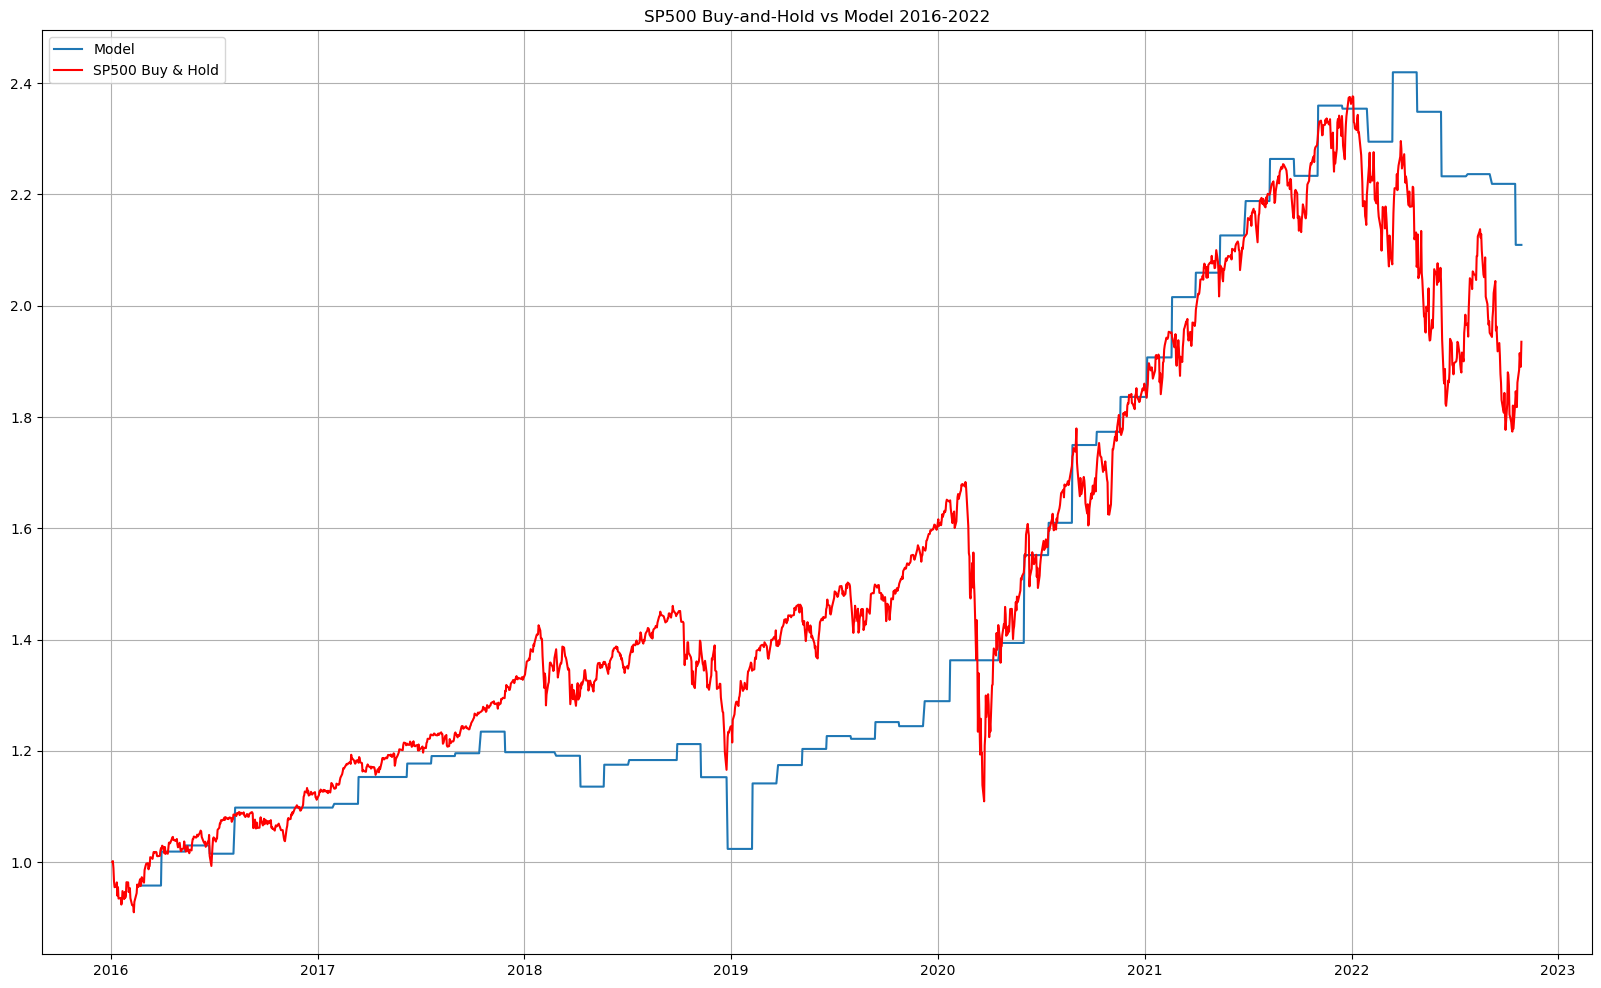

In [137]:
plot_returns(spy, strategies, 'SP500 Buy-and-Hold vs Model 2016-2022')

In [142]:
sp500_weekly = test.loc[test.index < '2021-01-01', :].copy()
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%period == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target']/100)
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

0.3762282741219024

In [145]:
strategy_weekly_return = strategies.loc[strategies.index < '2021-01-01', ['return']].fillna(1)
strategy_weekly_return = strategy_weekly_return.loc[strategy_weekly_return['return'] != 1, :].values - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.42540764657855845

In [144]:
sp500_weekly = test.copy()
sp500_weekly_return = []
for i in range(len(sp500_weekly)):
    if i%period == 0:
        sp500_weekly_return.append(sp500_weekly.iloc[i]['Target']/100)
    else:
        sp500_weekly_return.append(0)
temp_df = pd.DataFrame({'return': sp500_weekly_return}).shift(period)
temp_df =  temp_df.loc[temp_df['return'] != 0, 'return'].dropna()
sp500_sharpe = temp_df.mean()/temp_df.std()
sp500_sharpe

0.3023300574480291

In [146]:
strategy_weekly_return = strategies.loc[:, ['return']].fillna(1)
strategy_weekly_return = strategy_weekly_return.loc[strategy_weekly_return['return'] != 1, :].values - 1
strategy_sharpe = strategy_weekly_return.mean()/strategy_weekly_return.std()
strategy_sharpe

0.3779552656881282